In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
from path import Path

from feature_extraction.feature_extraction import CandidatesFeatureExtraction_MP
from machine_learning.cascade_classifier import CascadeClassifier
from candidate_proposal.morphology_mc import MorphologyCalcificationDetection, GSM_DEFAULT_PARAMS

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from metrics.metrics_utils import get_froc_df_of_many_imgs_features
from metrics.metrics import froc_curve
from general_utils.plots import plot_froc
import seaborn as sns
from database.dataset import *

In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['train', 'validation', 'test'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)


In [4]:
save_path = Path.cwd().parent.parent/'data/test_features/val/circular'

circ_all_features = pd.read_feather(str(save_path) + 'features.f')
circ_all_tps = pd.read_feather(str(save_path) + 'tps.f')
circ_all_fps = pd.read_feather(str(save_path) + 'fps.f')
circ_all_fns = pd.read_feather(str(save_path) + 'fns.f')
circ_all_ignored_candidates = pd.read_feather(str(save_path) + 'ignored_candidates.f')

In [5]:
save_path = Path.cwd().parent.parent/'data/test_features/val/square'

square_all_features = pd.read_feather(str(save_path) + 'features.f')
square_all_tps = pd.read_feather(str(save_path) + 'tps.f')
square_all_fps = pd.read_feather(str(save_path) + 'fps.f')
square_all_fns = pd.read_feather(str(save_path) + 'fns.f')
square_all_ignored_candidates = pd.read_feather(str(save_path) + 'ignored_candidates.f')

In [6]:
# circ_all_ignored_candidates['candidate_coordinates'] = (circ_all_ignored_candidates.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1)).astype(str)
circ_all_tps['candidate_coordinates_str'] = (circ_all_tps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
circ_all_tps['candidate_coordinates'] = (circ_all_tps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

circ_all_fps['candidate_coordinates_str'] = (circ_all_fps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
circ_all_fps['candidate_coordinates'] = (circ_all_fps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

circ_all_features['candidate_coordinates_str'] = circ_all_features.apply(lambda r:  f"[{r['candidate_coordinates'][0]}, {r['candidate_coordinates'][1]}, {r['candidate_coordinates'][2]}]", axis=1)

circ_all_tps_conf = circ_all_tps.merge(circ_all_features[['img_id', 'candidate_coordinates_str', 'confidence']], on=['img_id', 'candidate_coordinates_str'])
circ_all_fps_conf = circ_all_fps.merge(circ_all_features[['img_id', 'candidate_coordinates_str', 'confidence']], on=['img_id', 'candidate_coordinates_str'])

circle_cands = pd.concat([circ_all_tps_conf, circ_all_fps_conf])

circle_cands['label'] = circle_cands['label']=='TP'

In [7]:
# square_all_ignored_candidates['candidate_coordinates'] = (square_all_ignored_candidates.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1)).astype(str)
square_all_tps['candidate_coordinates_str'] = (square_all_tps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
square_all_tps['candidate_coordinates'] = (square_all_tps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

square_all_fps['candidate_coordinates_str'] = (square_all_fps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
square_all_fps['candidate_coordinates'] = (square_all_fps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

square_all_features['candidate_coordinates_str'] = square_all_features.apply(lambda r:  f"[{r['candidate_coordinates'][0]}, {r['candidate_coordinates'][1]}, {r['candidate_coordinates'][2]}]", axis=1)

square_all_tps_conf = square_all_tps.merge(square_all_features[['img_id', 'candidate_coordinates_str', 'confidence']], on=['img_id', 'candidate_coordinates_str'])
square_all_fps_conf = square_all_fps.merge(square_all_features[['img_id', 'candidate_coordinates_str', 'confidence']], on=['img_id', 'candidate_coordinates_str'])

squarele_cands = pd.concat([square_all_tps_conf, square_all_fps_conf])

squarele_cands['label'] = squarele_cands['label']=='TP'

In [8]:
cleaned_square = []

for img_id in squarele_cands.img_id.unique():
    img_df = squarele_cands[squarele_cands.img_id == img_id]
    cleaned_square.append(img_df.drop_duplicates(subset='repeted_idxs'))
    
cleaned_square = pd.concat(cleaned_square)
cleaned_square

,index,x,y,radius,label,repeted_idxs,matching_gt,img_id,candidate_coordinates_str,candidate_coordinates,confidence
0,0,984,2654,1,True,0.0,2.0,20587294,"[984, 2654, 1]","[984, 2654, 1]",0.999962
1,1,1514,1552,0,True,1.0,1.0,20587294,"[1514, 1552, 0]","[1514, 1552, 0]",0.796326
0,0,181,2947,1,False,2.0,NaN,20587294,"[181, 2947, 1]","[181, 2947, 1]",0.006179
1,1,96,2947,0,False,3.0,NaN,20587294,"[96, 2947, 0]","[96, 2947, 0]",0.000124
2,2,141,2947,2,False,4.0,NaN,20587294,"[141, 2947, 2]","[141, 2947, 2]",0.000394
...,...,...,...,...,...,...,...,...,...,...,...
108088,1630,8,250,0,False,1630.0,NaN,50998661,"[8, 250, 0]","[8, 250, 0]",0.003320
108089,1631,7,240,1,False,1631.0,NaN,50998661,"[7, 240, 1]","[7, 240, 1]",0.003238
108090,1632,14,239,0,False,1632.0,NaN,50998661,"[14, 239, 0]","[14, 239, 0]",0.003784
108091,1633,22,238,0,False,1633.0,NaN,50998661,"[22, 238, 0]","[22, 238, 0]",0.002537


In [9]:
normal_imgs_ids = db.get_normal_imgs_ids()


froc_df_1st = get_froc_df_of_many_imgs_features(
    circle_cands[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    circ_all_fns,
    circle_cands.confidence.values,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(
    froc_df_1st, non_max_supression=True, cut_on_50fpi=True)





froc_df_2st = get_froc_df_of_many_imgs_features(
    squarele_cands[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    square_all_fns,
    squarele_cands.confidence.values,
    normal_imgs_ids
)

sens2, avgs_fp_per_image2, _ = froc_curve(
    froc_df_2st, non_max_supression=True, cut_on_50fpi=True)

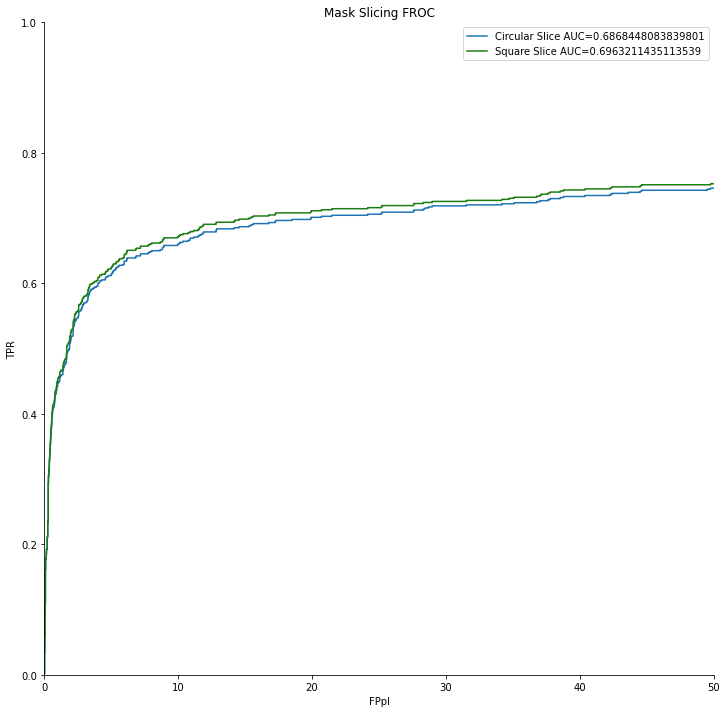

In [10]:
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(1, 1, 1)

plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs, color=(0.12, 0.46, 0.7, 1.0))


plot_froc(avgs_fp_per_image2, sens2, title='Mask Slicing FROC',
          cut_on_50fpi=True, ax=axs, color=(0.1, 0.49, 0.07, 1.0))

avgs_fp_per_image2 = np.asarray(avgs_fp_per_image2)
avgs_fp_per_image1 = np.asarray(avgs_fp_per_image1)
plt.legend([f'Circular Slice AUC={auc(avgs_fp_per_image1/avgs_fp_per_image1.max(), sens1)}',
            f'Square Slice AUC={auc(avgs_fp_per_image2/avgs_fp_per_image2.max(), sens2)}',
            ])


# plotting

In [22]:
img_id = 20587294
img_idx = db.df[db.df.img_id == img_id].index.values[0]

In [23]:
image = db[img_idx]['img']

In [24]:
from general_utils.plots import plot_detections, simple_im_show

In [25]:
tp = circ_all_tps_conf[circ_all_tps_conf.img_id == img_id]
fp = circ_all_fps_conf[circ_all_fps_conf.img_id == img_id]
fn = circ_all_fns[circ_all_fns.img_id == img_id]

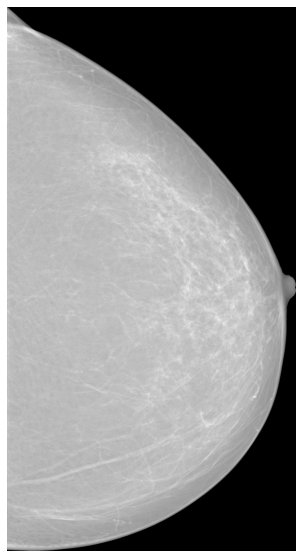

In [26]:
simple_im_show(image)

In [27]:
tp

,index,x,y,radius,label,repeted_idxs,matching_gt,img_id,candidate_coordinates_str,candidate_coordinates,confidence
0,0,984,2654,1,TP,0.0,2.0,20587294,"[984, 2654, 1]","[984, 2654, 1]",0.999962
1,1,1514,1552,0,TP,1.0,1.0,20587294,"[1514, 1552, 0]","[1514, 1552, 0]",0.796326


In [28]:
cands_tp = pd.DataFrame([tp['x'] - tp['radius'], tp['x'] + tp['radius'], tp['y'] - tp['radius'], tp['y'] + tp['radius'], tp['confidence'] ]).T.values
cands_fp = pd.DataFrame([fp['x'] - fp['radius'], fp['x'] + fp['radius'], fp['y'] - fp['radius'], fp['y'] + fp['radius'], fp['confidence'] ]).T.values

In [29]:
cands_fp = cands_fp[cands_fp[:,-1]>0.5]

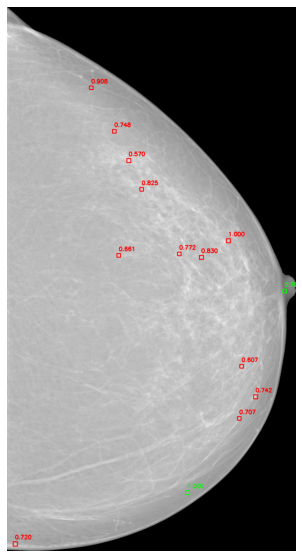

In [31]:
image = plot_detections(cands_tp, image, k=10, color=(0, 255, 0), return_image=True)
image = plot_detections(cands_fp, image, k=10, color=(0, 0, 255), return_image=True)

simple_im_show(image)

In [32]:
cv2.imwrite('tt.png', image)

True

In [30]:

def plot_detections(
    detections: np.ndarray, image: np.ndarray, k=15,
    gt_bboxes: List[tuple] = None, ax: int = None,
    color=(255, 0, 0), return_image=False
):
    """Draws red a rectangle (increased in k pixels on each side) on each
    detection, also writes the corresponding score.
    Args:
        detections (np.ndarray): array of detections bboxes [x1, x2, y1, y2, score].
        image (np.ndarray): image to use as a basis.
        k (int, optional): Extra size added in both direcitons to the bbox.
            Defaults to 10.
        gt_bboxes (List[tuple], optional): array of bboxes coordinates [((x1, y1), (x2, y2))].
            If provided plotted in green. Defaults to None.
        ax (bool, optional): Whether to plot the figure in the ax of another plot.
            Defaults to None.
        color (tuple, optional): Color use to plot bboxes and text.
            Defaults to red  (255, 0, 0).
        return_image (bool, optional): Whether to plot the figure or to return the image.
            Defaults to False (plot figure).
    
    Returns:
        image (np.ndarray): image with plotted bboxes if return_image=True, otherwise None
    """
    if len(image.shape) <3:
        image = utils.min_max_norm(image, 255).astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for [x1, x2, y1, y2, score] in detections:
        tl, br = utils.adjust_bbox_to_fit(image.shape, ((x1, y1), (x2, y2)), k)
        image = cv2.rectangle(image, tl, br, color, 2)
        label = f'{score:.3f}'
        y = tl[1]-15 if (tl[1]-15) > 15 else tl[1]+15
        image = cv2.putText(
            image, label, (int(x1), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    if gt_bboxes is not None:
        for ((x1, y1), (x2, y2)) in gt_bboxes:
            tl, br = utils.adjust_bbox_to_fit(image.shape, ((x1, y1), (x2, y2)), k)
            image = cv2.rectangle(image, tl, br, (0, 255, 0), 3)
            label = 'GT'
            y = tl[1]-15 if (tl[1]-15) > 15 else tl[1]+15
            image = cv2.putText(
                image, label, (int(x1), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    if return_image:
        return image
    else:
        ax_ = ax
        if ax_ is None:
            f, ax = plt.subplots(1, 1, figsize=(12, 12))
        ax.imshow(image)
        ax.axis('off')
        if ax_ is None:
            plt.show()